In [51]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats
import xgboost as xb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
titanic_train = pd.read_csv("train.csv")
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Data Cleaning and Preprocessing

First, it looks like we have a numerical feature that is really categorical, and which may be important for our classification, namely Pclass ( ticket class ). However, because there is a natural ordering of ticket classes that is expressed in their numbering, we should be fine if we just leave this as-is. 

PassengerId should have zero predictive effect, as it appears to be an arbitrary numbering. Names should also have no predictive effect. Any model that could use names to predict survival would likely be badly overfit. 

The variables we would expect to have predictive value here are Pclass, Sex, Age, SibSp, Parch, Fare, Cabin and Embarked. The predictive value of Embarked would likely be eaten up by other variables, but we'll leave it in anyway. 

At first glance, it looks as if Cabin is only a valid variable for passengers who travelled first-class. A closer examination of the data, however, shows that this is not the case. The vast majority of it is simply missing, we will have to delete it. 

There are many missing values for the Age variable. That data description says that estimated ages are prefixed with 'xx', however there are no cases of this in the training data. It seems reasonable to fill in missing values with the conditional expected value of Age given sex and ticket class. 

Ticket is a complex variable. Many of the values are numerical, but some have alphanumeric prefixes. There appears to 
be an association between the first number in a ticket and the associated class. It seems most reasonable to convert 
this to a categorical variable, there may be information here not contained in the other variables. 

In [3]:
#Drop Cabin
titanic_train = titanic_train.drop(['Cabin'], axis=1)

In [4]:
#Drop Name
titanic_train = titanic_train.drop(['Name'], axis=1 )

In [5]:
#Drop passenger id
titanic_train = titanic_train.drop(['PassengerId'], axis=1 )

## Define a function to process ticket values

Ticket values are either completely numeric or have an alphabetic prefix to a numeric value.
It can also be hypothesized that, as there appears to be an association between the first number in a ticket
number and the class of that passenger, the first number in a ticket number is the most important. Past this,
it is likely that the number of digits is the most significant piece of information. 

We have, for instance, the ticket numbers "STON/O2. 3101282" and "36973". Six or seven digit ticket numbers starting
with 3 appear to always belong to third class passengers, whereas the five-digit number "36973" belongs to a 
first-class passenger. Similarly, six or sevendigit ticket numbers starting with 2 seem to indicate second class 
passengers.

For this reason, I think it best to convert this variable to a categorical variable defined as follows:
    alphanumeric prefix + first digit + number of digits

In [6]:
#How many different values are in the Ticket column before transformation?
len( titanic_train['Ticket'].unique() )

681

In [7]:
#define a function to transform ticket numbers
def ticket_number_processor( ticket_num_array ):
    regex = re.compile('[^a-zA-Z]') #for stripping punctuation from prefixes
    ticket_num = []
    ticket_prefix = []
    for x in range(0, len(ticket_num_array)):
        #there is always whitespace between the prefix and the ticket number
        parts = ticket_num_array[x].split(' ')
        if len(parts) > 1: #we have a prefix
            ticket_prefix.append ( re.sub( regex, '', parts[0] )[:2] ) ##From examing the data, it would appear this much detail is 
            ##sufficient, and indeed optimal. Many of the ticket numbers appear almost identical except for a punct mark
            ticket_num.append( parts[1][0] + str( len(parts[1] )) )
        else: #no prefix
            ticket_prefix.append ("None" ) 
            ticket_num.append( parts[0][0] + str( len(parts[0])) )
    return np.array(ticket_num), np.array(ticket_prefix)
        

In [8]:
ticket_nums = titanic_train['Ticket'].as_matrix()
tn, tp = ticket_number_processor( ticket_nums )
titanic_train['TickPrefix'] = pd.Series( tp, index=titanic_train.index )
titanic_train['TickNum'] = pd.Series( tn, index=titanic_train.index )

In [9]:
# Check Ticket column
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TickPrefix,TickNum
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,A,25
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,PC,15
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,ST,37
3,1,1,female,35.0,1,0,113803,53.1000,S,None,16
4,0,3,male,35.0,0,0,373450,8.0500,S,None,36
5,0,3,male,NaN,0,0,330877,8.4583,Q,None,36
6,0,1,male,54.0,0,0,17463,51.8625,S,None,15
7,0,3,male,2.0,3,1,349909,21.0750,S,None,36
8,1,3,female,27.0,0,2,347742,11.1333,S,None,36
9,1,2,female,14.0,1,0,237736,30.0708,C,None,26


In [10]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 26
Number of unique TickPrefix entries: 16


We don't want a value in this categorical variable that occurs once, or only a few times. 

In [11]:
unq = titanic_train['TickPrefix'].unique() #get a list of every unique value in 'Ticket' column
tp_cdict = {} 
tn_cdict = {}
for val in unq:
    tp_cdict[val] = len ( titanic_train.index[ titanic_train['TickPrefix'] == val ])
print( "TickPrefix: ")
print( tp_cdict )

unq = titanic_train['TickNum'].unique() #get a list of every unique value in 'Ticket' column
count_dict = {} 
for val in unq:
    tn_cdict[val] = len ( titanic_train.index[ titanic_train['TickNum'] == val ])
print("TickNum")
print( tn_cdict )

TickPrefix: 
{'A': 28, 'PC': 60, 'ST': 18, 'None': 665, 'PP': 5, 'CA': 42, 'SC': 17, 'SP': 1, 'SO': 27, 'WC': 10, 'WE': 3, 'C': 5, 'Fa': 1, 'FC': 6, 'SW': 2, 'AS': 1}
TickNum
{'25': 45, '15': 149, '37': 32, '16': 72, '36': 263, '26': 88, '94': 3, '24': 97, '74': 12, '35': 43, '34': 15, '14': 10, '64': 9, '54': 5, '44': 12, '22': 12, '55': 3, '83': 1, 'L4': 4, '73': 3, '65': 3, 'B5': 1, '45': 3, '63': 2, '84': 2, '31': 2}


In [12]:
#functions to deal with uncommon values in TicketPref and TicketNum
def tp_uncommon( prefix ):
    if tp_cdict[ prefix ] < 6:
        return "Unc"
    else: return prefix

def tn_uncommon( prefix ):
    if tn_cdict[ prefix ] < 10:
        return "Unc"
    else: return prefix

titanic_train['TickPrefix'] = titanic_train['TickPrefix'].apply( tp_uncommon )
titanic_train['TickNum'] = titanic_train['TickNum'].apply( tn_uncommon )

In [13]:
titanic_train = titanic_train.drop(['Ticket'], axis=1)
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TickPrefix,TickNum
0,0,3,male,22.0,1,0,7.2500,S,A,25
1,1,1,female,38.0,1,0,71.2833,C,PC,15
2,1,3,female,26.0,0,0,7.9250,S,ST,37
3,1,1,female,35.0,1,0,53.1000,S,None,16
4,0,3,male,35.0,0,0,8.0500,S,None,36
5,0,3,male,NaN,0,0,8.4583,Q,None,36
6,0,1,male,54.0,0,0,51.8625,S,None,15
7,0,3,male,2.0,3,1,21.0750,S,None,36
8,1,3,female,27.0,0,2,11.1333,S,None,36
9,1,2,female,14.0,1,0,30.0708,C,None,26


In [14]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 14
Number of unique TickPrefix entries: 10


681 to 28 is a pretty good reduction, although we still have a relatively small sample for that many different values.
There are model types that can handle this, however.

## Age Preprocessing

In [15]:
# Find the median age for each combination of sex, ticket class and embarkation point
# I would try to do something with number of spouses etc., but they are mixed with number of siblings

missing_dict = {}
for tc, sex, ep in [ (t, s, e ) for t in (1, 2, 3) for s in ('male', 'female') for e in ('S', 'Q', 'C')]:
    #print( tc, sex, ep)
    i_set = titanic_train.index[ (titanic_train[ 'Pclass'] == tc) & (titanic_train['Sex'] == sex) & 
                                (titanic_train['Embarked'] == ep) ]
    rows = titanic_train.iloc[i_set]
    # Find where we have a missing age
    z_set = rows.index[ rows['Age'].isnull() ]
    med = rows['Age'].median()
    titanic_train['Age'].iloc[z_set] = med
    missing_dict[ (tc, sex, ep )] = med
    
titanic_train['Age'] = titanic_train['Age'].round(decimals=0)

In [16]:
#Print out our medians
print( missing_dict )

{(1, 'male', 'S'): 42.0, (1, 'male', 'Q'): 44.0, (1, 'male', 'C'): 36.5, (1, 'female', 'S'): 33.0, (1, 'female', 'Q'): 33.0, (1, 'female', 'C'): 37.0, (2, 'male', 'S'): 30.0, (2, 'male', 'Q'): 57.0, (2, 'male', 'C'): 29.5, (2, 'female', 'S'): 29.0, (2, 'female', 'Q'): 30.0, (2, 'female', 'C'): 22.0, (3, 'male', 'S'): 25.0, (3, 'male', 'Q'): 27.0, (3, 'male', 'C'): 26.0, (3, 'female', 'S'): 23.0, (3, 'female', 'Q'): 20.0, (3, 'female', 'C'): 14.25}


In [17]:
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,TickPrefix,TickNum
0,0,3,male,22.0,1,0,7.2500,S,A,25
1,1,1,female,38.0,1,0,71.2833,C,PC,15
2,1,3,female,26.0,0,0,7.9250,S,ST,37
3,1,1,female,35.0,1,0,53.1000,S,None,16
4,0,3,male,35.0,0,0,8.0500,S,None,36
5,0,3,male,27.0,0,0,8.4583,Q,None,36
6,0,1,male,54.0,0,0,51.8625,S,None,15
7,0,3,male,2.0,3,1,21.0750,S,None,36
8,1,3,female,27.0,0,2,11.1333,S,None,36
9,1,2,female,14.0,1,0,30.0708,C,None,26


### Age Preprocessing results

As we can see, there is a fair bit of information contained in ticket class, sex, and embarkation point that impacts
mean age. If our initial classificaiton results are unsatisfactory, it might be worth checking other variables as
well to get a more granular estimate. 

## Normality

Fare and age our only two real numeric variables, and as we can see below neither is normally distributed. 

In [18]:
##print out some basic statistics about our response's distribution
print("Fare Std: %f" % titanic_train['Fare'].std())
print("Fare Skewness: %f" % titanic_train['Fare'].skew() )
print( "Fare Kurtosis: %f" % titanic_train['Fare'].kurt() )
print("Age Std: %f" % titanic_train['Age'].std())
print("Age Skewness: %f" % titanic_train['Age'].skew() )
print( "Age Kurtosis: %f" % titanic_train['Age'].kurt() )

Fare Std: 49.693429
Fare Skewness: 4.787317
Fare Kurtosis: 33.398141
Age Std: 13.362592
Age Skewness: 0.518391
Age Kurtosis: 0.664954


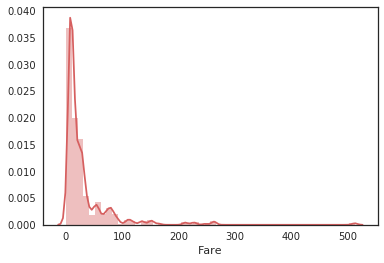

In [19]:
##Investigate Fare
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Fare'], color='r')

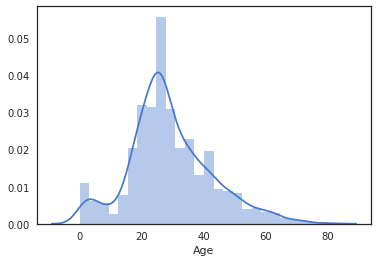

In [20]:
##Investigate Fare
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Age'], color='b')

Age is probably fine as-is. Fare, however, is highly skewed in the positive direciton. We will try Box-Cox. 

In [21]:
titanic_train['Fare'] = titanic_train['Fare'].apply( lambda x: x+1 )#add one for zero values

In [22]:
values = titanic_train['Fare'].values
values.shape
titanic_train['Fare'], _ = stats.boxcox( values )

Fare Std: 0.718497
Fare Skewness: -0.040329
Fare Kurtosis: 1.532277


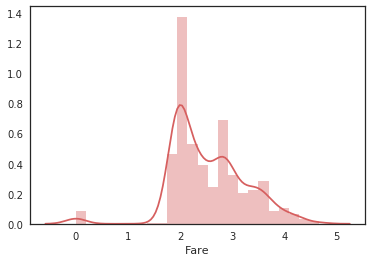

In [23]:
##Investigate Fare
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Fare'], color='r')
print("Fare Std: %f" % titanic_train['Fare'].std())
print("Fare Skewness: %f" % titanic_train['Fare'].skew() )
print( "Fare Kurtosis: %f" % titanic_train['Fare'].kurt() )

### Check for any remaining missing values

In [24]:
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      2
TickPrefix    0
TickNum       0
dtype: int64


In [25]:
##That's just two values out of ~800, so we'll just delete them rather than guess
missing_ind = titanic_train[ titanic_train['Embarked'].isnull()]
print( missing_ind.index )
titanic_train = titanic_train.drop( missing_ind.index )

Int64Index([61, 829], dtype='int64')


## Feature Engineering

Embarked needs a one-hot encoding.

Ticket number and sex need to be encoded numerically. 

We'll generate some new features by combining previous features. 

In [26]:
#Double-check we eliminated all missing values
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
TickPrefix    0
TickNum       0
dtype: int64


In [27]:
#One hot encoding for Embarked
l_encoder = LabelEncoder()
oh_encoder = OneHotEncoder(sparse=False, dtype=np.int )
titanic_train['Embarked'] = l_encoder.fit_transform(titanic_train['Embarked'])
emb = titanic_train['Embarked'].as_matrix()
emb = emb.reshape(-1, 1)
oh = oh_encoder.fit_transform(emb)

In [28]:
print(oh)

[[0 0 1]
 [1 0 0]
 [0 0 1]
 ..., 
 [0 0 1]
 [1 0 0]
 [0 1 0]]


In [29]:
print( oh.shape )
titanic_train['Emb0'] = pd.Series( oh[:,0], index=titanic_train.index )
titanic_train['Emb1'] = pd.Series( oh[:,1], index=titanic_train.index )
titanic_train['Emb2'] = pd.Series( oh[:,2], index=titanic_train.index )
titanic_train = titanic_train.drop( ['Embarked'], axis=1 )
titanic_train.head(10)

(889, 3)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TickPrefix,TickNum,Emb0,Emb1,Emb2
0,0,3,male,22.0,1,0,1.906724,A,25,0,0,1
1,1,1,female,38.0,1,0,3.497640,PC,15,1,0,0
2,1,3,female,26.0,0,0,1.970459,ST,37,0,0,1
3,1,1,female,35.0,1,0,3.304258,None,16,0,0,1
4,0,3,male,35.0,0,0,1.981680,None,36,0,0,1
5,0,3,male,27.0,0,0,2.017180,None,36,0,1,0
6,0,1,male,54.0,0,0,3.288577,None,15,0,0,1
7,0,3,male,2.0,3,1,2.670118,None,36,0,0,1
8,1,3,female,27.0,0,2,2.214698,None,36,0,0,1
9,1,2,female,14.0,1,0,2.918516,None,26,1,0,0


In [30]:
#Label encoding for TickPrefix, TickNum, and Sex
titanic_train['TickPrefix'] = l_encoder.fit_transform( titanic_train['TickPrefix'])
titanic_train['TickNum'] = l_encoder.fit_transform( titanic_train['TickNum'])
titanic_train['Sex'] = l_encoder.fit_transform( titanic_train['Sex'])
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TickPrefix,TickNum,Emb0,Emb1,Emb2
0,0,3,1,22.0,1,0,1.906724,0,5,0,0,1
1,1,1,0,38.0,1,0,3.497640,4,1,1,0,0
2,1,3,0,26.0,0,0,1.970459,7,10,0,0,1
3,1,1,0,35.0,1,0,3.304258,3,2,0,0,1
4,0,3,1,35.0,0,0,1.981680,3,9,0,0,1
5,0,3,1,27.0,0,0,2.017180,3,9,0,1,0
6,0,1,1,54.0,0,0,3.288577,3,1,0,0,1
7,0,3,1,2.0,3,1,2.670118,3,9,0,0,1
8,1,3,0,27.0,0,2,2.214698,3,9,0,0,1
9,1,2,0,14.0,1,0,2.918516,3,6,1,0,0


### LabelCount

LabelEncoder uses the native Python ordering to determine which class gets a certain value, i.e. to determine what
the integer value of a class in Ticket is, the encoder sorts all the classes and uses its position in that ordering.

It would be better if this label was determined by how often a class occurs. 

In [31]:
#assumes we have already used LabelEncoder from scikit learn
#transforms the labels so they are ordered by how often they occur, i.e. 1 will be the most common class
def label_count_encoder( df, col ):
    unq = df[col ].unique() #get a list of every unique value in 'Ticket' column
    count_dict = {} 
    for val in unq:
        count_dict[val] = len ( df.index[ df[col] == val ])
    print( count_dict )
    #get list of entries, sorted by value
    occ_list = sorted(count_dict.items(), key=lambda x: x[1])
    print(occ_list)
    #make new dict
    occ_dict = {}
    for x in range(len(occ_list), 0, -1):
        occ_dict[occ_list[x-1][0]] = ( len(occ_list) - ( x - 1 ))
    print(occ_dict)
    ##apply
    def apply_order( entry ):
        return occ_dict[entry]
    df[col] = df[col].apply( apply_order )

label_count_encoder( titanic_train, 'TickPrefix' )
label_count_encoder( titanic_train, 'TickNum' )
titanic_train.head(10)

{0: 28, 4: 60, 7: 18, 3: 663, 8: 18, 1: 42, 5: 17, 6: 27, 9: 10, 2: 6}
[(2, 6), (9, 10), (5, 17), (7, 18), (8, 18), (6, 27), (0, 28), (1, 42), (4, 60), (3, 663)]
{3: 1, 4: 2, 1: 3, 0: 4, 6: 5, 8: 6, 7: 7, 5: 8, 9: 9, 2: 10}
{5: 45, 1: 149, 10: 32, 2: 70, 9: 263, 6: 88, 13: 41, 4: 97, 12: 12, 8: 43, 7: 15, 0: 10, 11: 12, 3: 12}
[(0, 10), (12, 12), (11, 12), (3, 12), (7, 15), (10, 32), (13, 41), (8, 43), (5, 45), (2, 70), (6, 88), (4, 97), (1, 149), (9, 263)]
{9: 1, 1: 2, 4: 3, 6: 4, 2: 5, 5: 6, 8: 7, 13: 8, 10: 9, 7: 10, 3: 11, 11: 12, 12: 13, 0: 14}


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TickPrefix,TickNum,Emb0,Emb1,Emb2
0,0,3,1,22.0,1,0,1.906724,4,6,0,0,1
1,1,1,0,38.0,1,0,3.497640,2,2,1,0,0
2,1,3,0,26.0,0,0,1.970459,7,9,0,0,1
3,1,1,0,35.0,1,0,3.304258,1,5,0,0,1
4,0,3,1,35.0,0,0,1.981680,1,1,0,0,1
5,0,3,1,27.0,0,0,2.017180,1,1,0,1,0
6,0,1,1,54.0,0,0,3.288577,1,2,0,0,1
7,0,3,1,2.0,3,1,2.670118,1,1,0,0,1
8,1,3,0,27.0,0,2,2.214698,1,1,0,0,1
9,1,2,0,14.0,1,0,2.918516,1,4,1,0,0


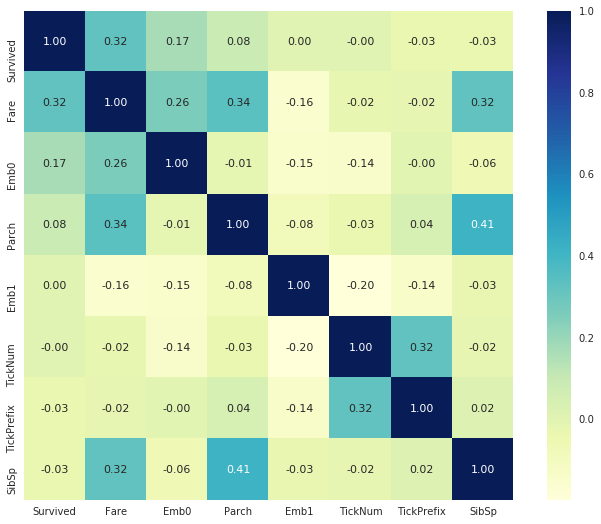

In [32]:
##build a correlation heatmap using the ~10 highest correlated predictors
f, ax = plt.subplots(figsize=(12, 9))
correlation_matrix = titanic_train.corr()
cols = correlation_matrix.nlargest(8, 'Survived')['Survived'].index
cm = np.corrcoef(titanic_train[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### New Features: From Numerical

Our three numerical features are Age, SibSp, Parch, and Fare. We can make some new features here by adding polynomials
on them, additive features with their combinations, and multiplicative features with their combinations

In [33]:
rb = RobustScaler()
#scaling
titanic_train['Age'] = rb.fit_transform( titanic_train['Age'].as_matrix().reshape(-1,1) )
titanic_train['Fare'] = rb.fit_transform( titanic_train['Fare'].as_matrix().reshape(-1,1))
titanic_train['SibSp'] = rb.fit_transform( titanic_train['SibSp'].as_matrix().reshape(-1,1) )
titanic_train['Parch'] = rb.fit_transform( titanic_train['Parch'].as_matrix().reshape(-1,1))
#polynomials
titanic_train['Age^2'] = titanic_train['Age']**2
titanic_train['Fare^2'] = titanic_train['Fare']**2
titanic_train['SibSp^2'] = titanic_train['SibSp']**2
titanic_train['Parch^2'] = titanic_train['Parch']**2
#additive
titanic_train['SibSp+Parch'] = titanic_train['SibSp'] + titanic_train['Parch']
titanic_train['SibSp+Fare'] = titanic_train['SibSp'] + titanic_train['Fare']
titanic_train['SibSp+Age'] = titanic_train['SibSp'] + titanic_train['Age']
titanic_train['Parch+Age'] = titanic_train['Parch'] + titanic_train['Age']
titanic_train['Parch+Fare'] = titanic_train['Parch'] + titanic_train['Fare']
titanic_train['Age+Fare'] = titanic_train['Age'] + titanic_train['Fare']
#multiplicative
titanic_train['SibSp*Parch'] = titanic_train['SibSp'] * titanic_train['Parch']
titanic_train['SibSp*Fare'] = titanic_train['SibSp'] * titanic_train['Fare']
titanic_train['SibSp*Age'] = titanic_train['SibSp'] * titanic_train['Age']
titanic_train['Parch*Age'] = titanic_train['Parch'] * titanic_train['Age']
titanic_train['Parch*Fare'] = titanic_train['Parch'] * titanic_train['Fare']
titanic_train['Age*Fare'] = titanic_train['Age'] * titanic_train['Fare']

In [34]:
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TickPrefix,TickNum,Emb0,...,SibSp+Age,Parch+Age,Parch+Fare,Age+Fare,SibSp*Parch,SibSp*Fare,SibSp*Age,Parch*Age,Parch*Fare,Age*Fare
0,0,3,1,-0.333333,1.0,0.0,-0.509691,4,6,0,...,0.666667,-0.333333,-0.509691,-0.843024,0.0,-0.509691,-0.333333,-0.000000,-0.000000,0.169897
1,1,1,0,0.733333,1.0,0.0,1.127508,2,2,1,...,1.733333,0.733333,1.127508,1.860841,0.0,1.127508,0.733333,0.000000,0.000000,0.826839
2,1,3,0,-0.066667,0.0,0.0,-0.444102,7,9,0,...,-0.066667,-0.066667,-0.444102,-0.510769,0.0,-0.000000,-0.000000,-0.000000,-0.000000,0.029607
3,1,1,0,0.533333,1.0,0.0,0.928501,1,5,0,...,1.533333,0.533333,0.928501,1.461834,0.0,0.928501,0.533333,0.000000,0.000000,0.495200
4,0,3,1,0.533333,0.0,0.0,-0.432555,1,1,0,...,0.533333,0.533333,-0.432555,0.100778,0.0,-0.000000,0.000000,0.000000,-0.000000,-0.230696
5,0,3,1,0.000000,0.0,0.0,-0.396022,1,1,0,...,0.000000,0.000000,-0.396022,-0.396022,0.0,-0.000000,0.000000,0.000000,-0.000000,-0.000000
6,0,1,1,1.800000,0.0,0.0,0.912363,1,2,0,...,1.800000,1.800000,0.912363,2.712363,0.0,0.000000,0.000000,0.000000,0.000000,1.642254
7,0,3,1,-1.666667,3.0,1.0,0.275912,1,1,0,...,1.333333,-0.666667,1.275912,-1.390755,3.0,0.827736,-5.000000,-1.666667,0.275912,-0.459853
8,1,3,0,0.000000,0.0,2.0,-0.192758,1,1,0,...,0.000000,2.000000,1.807242,-0.192758,0.0,-0.000000,0.000000,0.000000,-0.385516,-0.000000
9,1,2,0,-0.866667,1.0,0.0,0.531536,1,4,1,...,0.133333,-0.866667,0.531536,-0.335131,0.0,0.531536,-0.866667,-0.000000,0.000000,-0.460664


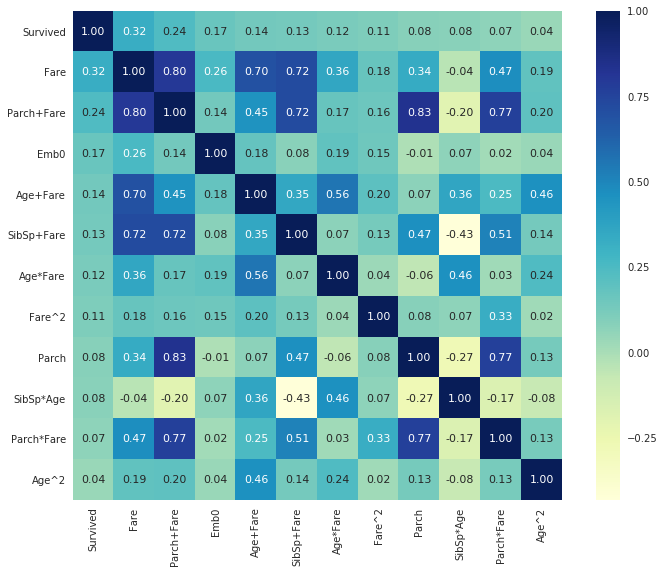

In [35]:
##build a correlation heatmap using the ~10 highest correlated predictors
f, ax = plt.subplots(figsize=(12, 9))
correlation_matrix = titanic_train.corr()
cols = correlation_matrix.nlargest(12, 'Survived')['Survived'].index
cm = np.corrcoef(titanic_train[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [38]:
y = titanic_train['Survived']
titanic_train = titanic_train.drop(['Survived'], axis=1)
X = titanic_train
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [39]:
X.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,TickPrefix,TickNum,Emb0,Emb1,...,SibSp+Age,Parch+Age,Parch+Fare,Age+Fare,SibSp*Parch,SibSp*Fare,SibSp*Age,Parch*Age,Parch*Fare,Age*Fare
0,3,1,-0.333333,1.0,0.0,-0.509691,4,6,0,0,...,0.666667,-0.333333,-0.509691,-0.843024,0.0,-0.509691,-0.333333,-0.0,-0.0,0.169897
1,1,0,0.733333,1.0,0.0,1.127508,2,2,1,0,...,1.733333,0.733333,1.127508,1.860841,0.0,1.127508,0.733333,0.0,0.0,0.826839
2,3,0,-0.066667,0.0,0.0,-0.444102,7,9,0,0,...,-0.066667,-0.066667,-0.444102,-0.510769,0.0,-0.000000,-0.000000,-0.0,-0.0,0.029607
3,1,0,0.533333,1.0,0.0,0.928501,1,5,0,0,...,1.533333,0.533333,0.928501,1.461834,0.0,0.928501,0.533333,0.0,0.0,0.495200
4,3,1,0.533333,0.0,0.0,-0.432555,1,1,0,0,...,0.533333,0.533333,-0.432555,0.100778,0.0,-0.000000,0.000000,0.0,-0.0,-0.230696


In [49]:
kn = KNeighborsClassifier(n_neighbors=20)
print( cross_val_score(kn, X, y ))

[ 0.7037037   0.73648649  0.78040541]


In [50]:
svc = svm.SVC()
print( cross_val_score(svc, X, y))

[ 0.78114478  0.79391892  0.83445946]


In [53]:
log_reg = LogisticRegression()
print( cross_val_score(log_reg, X, y))

[ 0.78451178  0.82094595  0.81081081]


In [54]:
ada = AdaBoostClassifier()
print( cross_val_score( ada, X, y))

[ 0.77441077  0.79391892  0.82432432]
